In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Activation, concatenate, Dense, Attention, Reshape, Subtract, Average, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.metrics import AUC
from scipy.io import loadmat
import h5py
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
from sklearn.metrics import precision_recall_curve
import tensorflow as tf
from tensorflow.keras import layers, models
import pickle
from tensorflow.keras.optimizers.schedules import ExponentialDecay

- https://github.com/paulgavrikov/visualkeras

In [ ]:
pip install visualkeras

In [ ]:
import visualkeras
from IPython.display import display

# SqueezeNet baseline
This is the baseline model previously used in another study with post optical images for building damage classification.


In [ ]:
def hybrid_resample(X, y, seed=1):
  '''
  Oversampling minority class and undersampling majority class.
  This is done due to limited memory.
  '''
  np.random.seed(seed)

  X_major = X[y == 0]
  X_minor = X[y == 1]

  n_major = len(X_major)
  n_minor = len(X_minor)
  target_n = int((n_major + n_minor) / 2)

  indices_major = np.random.choice(n_major, target_n, replace=False)
  X_major_balanced = X_major[indices_major]

  indices_minor = np.random.choice(n_minor, target_n, replace=True)
  X_minor_balanced = X_minor[indices_minor]

  X_balanced = np.concatenate([X_major_balanced, X_minor_balanced])
  y_balanced = np.array([0] * target_n + [1] * target_n)

  idx = np.random.permutation(len(y_balanced))
  return X_balanced[idx], y_balanced[idx]


In [4]:
def fire_module(x, squeeze_filters, expand_filters):
  '''
  Main component of squeezeNet.
  '''
  squeeze = Conv2D(squeeze_filters, (1, 1), activation='relu', padding='same')(x)
  expand1x1 = Conv2D(expand_filters, (1, 1), activation='relu', padding='same')(squeeze)
  expand3x3 = Conv2D(expand_filters, (3, 3), activation='relu', padding='same')(squeeze)
  return concatenate([expand1x1, expand3x3], axis=-1)


def build_squeezenet(input_shape=(96, 96, 4)):
  '''
  Baseline squeezeNet model.
  '''
  inputs = Input(shape=input_shape)
  x = Conv2D(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(inputs)
  x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
  x = fire_module(x, squeeze_filters=16, expand_filters=64)
  x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
  x = fire_module(x, squeeze_filters=32, expand_filters=128)
  x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
  x = fire_module(x, squeeze_filters=48, expand_filters=192)
  x = Dropout(0.5)(x)
  x = Conv2D(1, (1, 1), padding='same')(x)
  x = GlobalAveragePooling2D()(x)
  outputs = Activation('sigmoid')(x)

  model = Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer=AdamW(), loss='binary_crossentropy', metrics=['Precision', 'Recall', AUC(curve='ROC', name='AUC')])
  return model

In [ ]:
# DATA LOADING ONLY IF YOU HAVE NOT LOADED YET.
# Pickle file is used so that the data does not have to be loaded everytime since during my reserach I have tried many approaches of models
# and this saved time by not having to load the data on the fly and keeps images in format that is expected by CNNs.
split_csv_folder = "/content/drive/MyDrive/Data/split_csvs"
search_dirs = [
    "/content/drive/MyDrive/Data/earthquake_building_dataset/damaged",
    "/content/drive/MyDrive/Data/earthquake_building_dataset/intact"
]

def convert_to_drive_path(original_path):
  '''
  The paths in my split csvs are based on my local paths so they had to be converted to google drive paths.
  '''
  filename = os.path.basename(original_path)
  subfolder = 'damaged' if 'damaged' in original_path.lower() else 'intact'
  return f"/content/drive/MyDrive/Data/earthquake_building_dataset/{subfolder}/{filename}"

def load_and_stack_input(opt_path, mask_path, target_size=(96, 96)):
  with h5py.File(opt_path, 'r') as f_opt:
    opt_data = np.array(f_opt['x3'])
  opt_data = np.transpose(opt_data, (1, 2, 0))

  with h5py.File(mask_path, 'r') as f_mask:
    mask_data = np.array(f_mask['x4'])
  mask_data = (mask_data > 0).astype(np.float32)
  mask_data = np.expand_dims(mask_data, axis=-1)

  stacked_input = np.concatenate([opt_data, mask_data], axis=-1)

  stacked_input_resized = cv2.resize(stacked_input, target_size, interpolation=cv2.INTER_LINEAR)

  return stacked_input_resized

split_files = sorted([f for f in os.listdir(split_csv_folder) if f.endswith(".csv")])
all_data = []

for split_file in split_files:
  df = pd.read_csv(os.path.join(split_csv_folder, split_file))
  X_split, y_split = [], []
  for _, row in tqdm(df.iterrows(), desc=f"Loading {split_file}"):
    opt_path = convert_to_drive_path(row['post_optical_mat'])
    mask_path = convert_to_drive_path(row['post_optical_footprint_mat'])
    input_stack = load_and_stack_input(opt_path, mask_path)
    if input_stack is not None:
      X_split.append(input_stack)
      y_split.append(row['label'])
  all_data.append({
      'X': np.array(X_split),
      'y': np.array(y_split)
  })
with open("/content/drive/MyDrive/Processed data/all_data.pkl", "wb") as f:
  pickle.dump(all_data, f)

Split 1 has 801 samples.


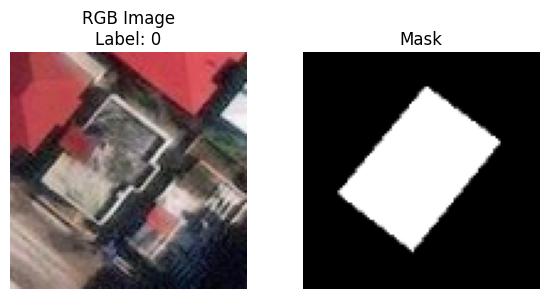

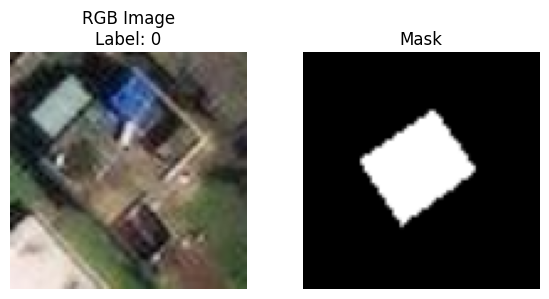

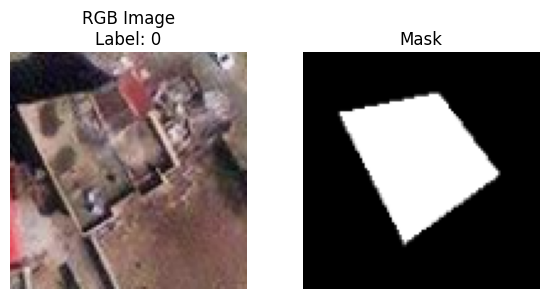

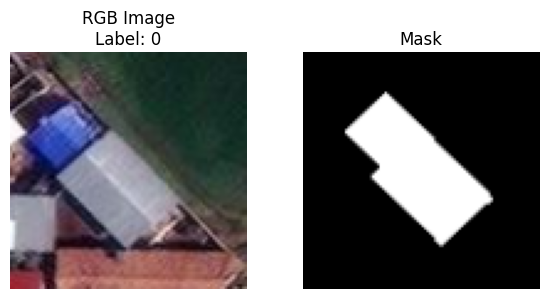

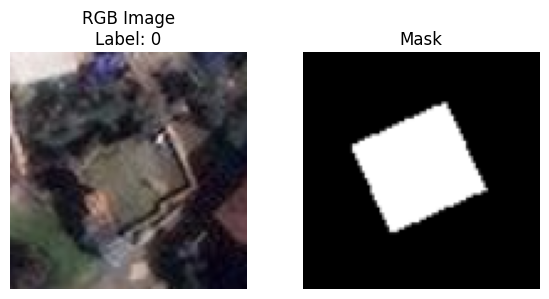

In [7]:
# Inspect the pkl file to check if saving went correct.
pkl_path = "/content/drive/MyDrive/Processed data/all_data.pkl"

with open(pkl_path, "rb") as f:
  all_data = pickle.load(f)

split_index = 0

split_data = all_data[split_index]
X = split_data["X"]
y = split_data["y"]

print(f"Split {split_index + 1} has {len(X)} samples.")

num_samples = 5

for i in range(num_samples):
  img = X[i]
  label = y[i]

  rgb = img[..., :3].astype(np.uint8)
  mask = img[..., 3]

  fig, axs = plt.subplots(1, 2, figsize=(6, 3))

  axs[0].imshow(rgb)
  axs[0].set_title(f"RGB Image\nLabel: {label}")
  axs[0].axis("off")

  axs[1].imshow(mask, cmap="gray")
  axs[1].set_title("Mask")
  axs[1].axis("off")

  plt.tight_layout()
  plt.show()


Round 1
Test split: Split 1
Class Distribution:
Train after resample - Intact (0): 1604, Damaged (1): 1604
Test  - Intact (0): 767, Damaged (1): 34
Epoch 1/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - AUC: 0.6250 - Precision: 0.5645 - Recall: 0.5436 - loss: 0.6690
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.8151 - Precision: 0.7588 - Recall: 0.7275 - loss: 0.5275
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.8152 - Precision: 0.7400 - Recall: 0.7029 - loss: 0.5342
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.8487 - Precision: 0.7922 - Recall: 0.7096 - loss: 0.4796
Epoch 5/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.8918 - Precision: 0.8352 - Recall: 0.7440 - loss: 0.4234
Epoch 6/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - AUC: 0.9017 - Precision: 0.8407 - Recall: 0.8028 - loss: 0.3957
Epoch 7/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - AUC: 0.9337 - Precision: 0.8705 - Recall: 0.8395 - loss: 0.3361
Epoch 8/30
101/101 ━━━

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


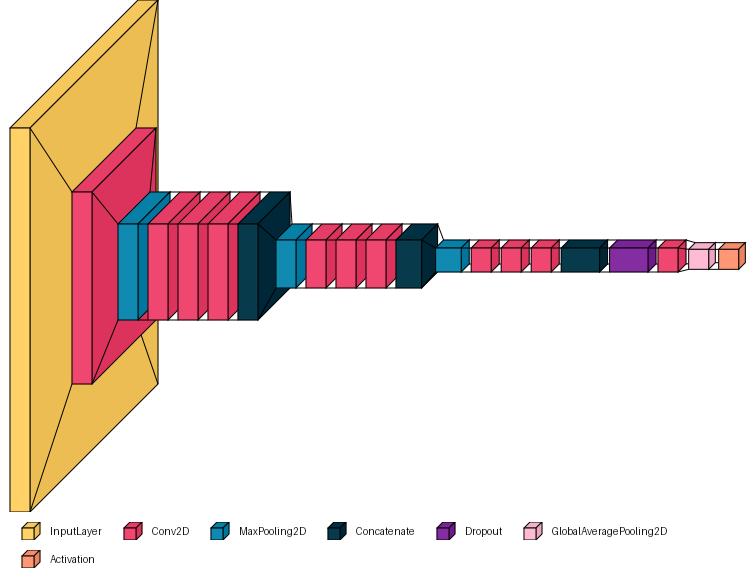

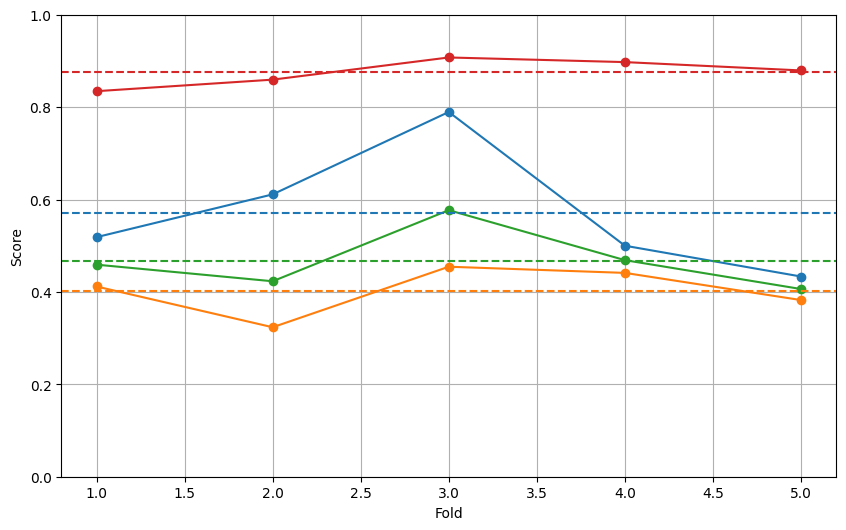

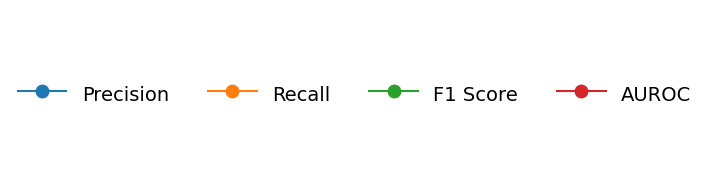

In [ ]:
with open("/content/drive/MyDrive/Processed data/all_data.pkl", "rb") as f:
  all_data = pickle.load(f)

split_files = [f"Split {i+1}" for i in range(len(all_data))]

all_precisions = []
all_recalls = []
all_f1s = []
all_aurocs = []

for test_idx in range(5):
  print(f"Round {test_idx + 1}")
  print(f"Test split: {split_files[test_idx]}")

  X_test, y_test = all_data[test_idx]['X'], all_data[test_idx]['y']
  train_indices = [i for i in range(5) if i != test_idx]
  X_train = np.concatenate([all_data[i]['X'] for i in train_indices])
  y_train = np.concatenate([all_data[i]['y'] for i in train_indices])


  X_train, y_train = hybrid_resample(X_train, y_train)

  train_counts = np.bincount(y_train)
  test_counts = np.bincount(y_test)

  print(f"Class Distribution:")
  print(f"Train after resample - Intact (0): {train_counts[0]}, Damaged (1): {train_counts[1]}")
  print(f"Test  - Intact (0): {test_counts[0]}, Damaged (1): {test_counts[1]}")



  X_train = X_train.astype('float32') / 255.0
  X_test = X_test.astype('float32') / 255.0

  model = build_squeezenet(input_shape=X_train.shape[1:])
  history = model.fit(
      X_train, y_train,
      epochs=30,
      batch_size=32,
      verbose=1
  )


  y_pred_probs = model.predict(X_test).squeeze()

  precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_probs)

  f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

  best_idx = np.argmax(f1_scores)
  best_threshold = thresholds[best_idx]
  print(f"Best F1 Threshold: {best_threshold:.4f} — F1: {f1_scores[best_idx]:.4f}")

  y_pred = (y_pred_probs > best_threshold).astype(int)

  precision = precision_score(y_test, y_pred, zero_division=0)
  recall = recall_score(y_test, y_pred, zero_division=0)
  f1 = f1_score(y_test, y_pred, zero_division=0)
  auroc = roc_auc_score(y_test, y_pred_probs)

  all_aurocs.append(auroc)

  all_precisions.append(precision)
  all_recalls.append(recall)
  all_f1s.append(f1)

  print("Detailed Evaluation:")
  print(classification_report(
      y_test, y_pred,
      target_names=['Intact (0)', 'Damaged (1)'],
      digits=4,
      zero_division=0
  ))

print("Final Cross-Validation Results")
print(f"Mean Precision: {np.mean(all_precisions):.4f}")
print(f"Mean Recall: {np.mean(all_recalls):.4f}")
print(f"Mean F1 Score: {np.mean(all_f1s):.4f}")
print(f"Mean AUROC: {np.mean(all_aurocs):.4f}")

# Note: this will give population standard deviation. This is later fixed in my thesis to sample standard deviation.
print(f"Std. dev Precision: {np.std(all_precisions):.4f}")
print(f"Std. dev Recall: {np.std(all_recalls):.4f}")
print(f"Std. dev F1 Score: {np.std(all_f1s):.4f}")
print(f"Std. dev AUROC: {np.std(all_aurocs):.4f}")

img = visualkeras.layered_view(model, legend=True)
display(img)


metrics = {
    'Precision': all_precisions,
    'Recall': all_recalls,
    'F1 Score': all_f1s,
    'AUROC': all_aurocs
}

folds = list(range(1, 6))

fig, ax = plt.subplots(figsize=(10, 6))
precision_line, = ax.plot(folds, all_precisions, marker='o', label='Precision')
recall_line, = ax.plot(folds, all_recalls, marker='o', label='Recall')
f1_line, = ax.plot(folds, all_f1s, marker='o', label='F1 Score')
auroc_line, = ax.plot(folds, all_aurocs, marker='o', label='AUROC')

ax.axhline(np.mean(all_f1s), color=f1_line.get_color(), linestyle='--', label='Mean F1')
ax.axhline(np.mean(all_precisions), color=precision_line.get_color(), linestyle='--', label='Mean Precision')
ax.axhline(np.mean(all_recalls), color=recall_line.get_color(), linestyle='--', label='Mean Recall')
ax.axhline(np.mean(all_aurocs), color=auroc_line.get_color(), linestyle='--', label='Mean AUROC')

ax.set_xlabel('Fold')
ax.set_ylabel('Score')
ax.set_ylim(0, 1)
ax.grid(True)

plt.show()

fig_legend = plt.figure(figsize=(6, 2))

legend = fig_legend.legend(
    handles=[precision_line, recall_line, f1_line, auroc_line],
    labels=['Precision', 'Recall', 'F1 Score', 'AUROC'],
    loc='center',
    ncol=4,
    frameon=False,
    fontsize=14,
    handlelength=2.5,
    handleheight=2.0,
    markerscale=1.5
)

plt.axis('off')
plt.tight_layout()
plt.show()

# Pre and post shadow data loader


In [ ]:
class ShadowDatasetLoader:
    def __init__(self, split_csv_folder, save_path, input_size=(96, 96), use_pickle=True):

      self.split_csv_folder = split_csv_folder
      self.save_path = save_path
      self.input_size = input_size
      self.use_pickle = use_pickle

      self.post_optical_dirs = {
          'damaged': "/content/drive/MyDrive/Data (1)/earthquake_building_dataset (1)/damaged (1)",
          'intact': "/content/drive/MyDrive/Data (1)/earthquake_building_dataset (1)/intact (1)"
      }
      self.pre_optical_dirs = {
          'damaged': "/content/drive/MyDrive/Data (1)/pre earthquake data (1)/pre turkey damaged patches (1)",
          'intact': "/content/drive/MyDrive/Data (1)/pre earthquake data (1)/pre turkey earthquake patches (1)"
      }
      self.pre_shadow_dirs = {
          'damaged': "/content/drive/MyDrive/Data (1)/pre shadows (1)/Damaged (1)",
          'intact': "/content/drive/MyDrive/Data (1)/pre shadows (1)/Intact (1)"
      }
      self.post_shadow_dirs = {
          'damaged': "/content/drive/MyDrive/Data (1)/post shadows (1)/Damaged (1)",
          'intact': "/content/drive/MyDrive/Data (1)/post shadows (1)/Intact (1)"
      }

    def convert_paths(self, osm_id, label):
      '''
      This function converts local paths from my csv splits to the ones in google drive for google collab.
      '''
      label_str = 'damaged' if label == 1 else 'intact'
      return {
          'osm_id': str(osm_id),
          'label': label_str,
          'pre_optical': os.path.join(self.pre_optical_dirs[label_str], f"{osm_id}_opt_pre (1).png"),
          'pre_shadow': os.path.join(self.pre_shadow_dirs[label_str], f"{osm_id}_pre_shadow (1).png"),
          'post_shadow': os.path.join(self.post_shadow_dirs[label_str], f"{osm_id}_post_shadow (1).png"),
          'post_mat': os.path.join(self.post_optical_dirs[label_str], f"{osm_id}_opt (1).mat"),
      }  # Return dictionary with the images path as values.

    def load_image_pair(self, paths):
      '''
      This function makes sure all images are loaded correctly.
      '''
      with h5py.File(paths['post_mat'], 'r') as f:
        post_opt = np.array(f['x3']).transpose(1, 2, 0)

      pre_opt = cv2.imread(paths['pre_optical'], cv2.IMREAD_COLOR)
      pre_shadow = cv2.imread(paths['pre_shadow'], cv2.IMREAD_GRAYSCALE)
      post_shadow = cv2.imread(paths['post_shadow'], cv2.IMREAD_GRAYSCALE)

      pre_opt = cv2.cvtColor(pre_opt, cv2.COLOR_BGR2RGB)
      pre_shadow = np.expand_dims((pre_shadow > 0).astype(np.float32), -1)
      post_shadow = np.expand_dims((post_shadow > 0).astype(np.float32), -1)

      pre_input = np.concatenate([pre_opt, pre_shadow], axis=-1)
      post_input = np.concatenate([post_opt, post_shadow], axis=-1)

      pre_input = cv2.resize(pre_input, self.input_size)
      post_input = cv2.resize(post_input, self.input_size)

      return pre_input, post_input


    def load_or_generate_data(self):
      '''
      This function loads all data by storing them in a list of dictionaries in a pickle file to make sure the data does not have to be loaded every time.
      '''
      if self.use_pickle and os.path.exists(self.save_path):
          with open(self.save_path, 'rb') as f:
              return pickle.load(f)

      all_shadow_data = []

      split_files = sorted([f for f in os.listdir(self.split_csv_folder) if f.endswith('.csv')])
      for split_file in split_files:
        df = pd.read_csv(os.path.join(self.split_csv_folder, split_file))
        X_pre, X_post, y = [], [], []

        for _, row in tqdm(df.iterrows(), desc=f"Processing {split_file}", total=len(df)):
          paths = self.convert_paths(row['osm_id'], row['label'])
          pre_input, post_input = self.load_image_pair(paths)

          if pre_input is not None and post_input is not None:
            X_pre.append(pre_input)
            X_post.append(post_input)
            y.append(row['label'])

        all_shadow_data.append({
            'X_pre': np.array(X_pre),
            'X_post': np.array(X_post),
            'y': np.array(y)
        })

      if self.use_pickle:  # Saves the loaded data using pickle this ensures this process only has to be done once.
        with open(self.save_path, 'wb') as f:
          pickle.dump(all_shadow_data, f)
        print(f"Saved data to: {self.save_path}")

      return all_shadow_data

In [ ]:
shadow_loader = ShadowDatasetLoader(
    split_csv_folder="/content/drive/MyDrive/Data (1)/split_csvs (1)",
    save_path="/content/drive/MyDrive/Processed data/all_data_shadow.pkl",
    input_size=(96, 96),
    use_pickle=True
)

all_data_shadow = shadow_loader.load_or_generate_data()

Split 1 has 801 samples.


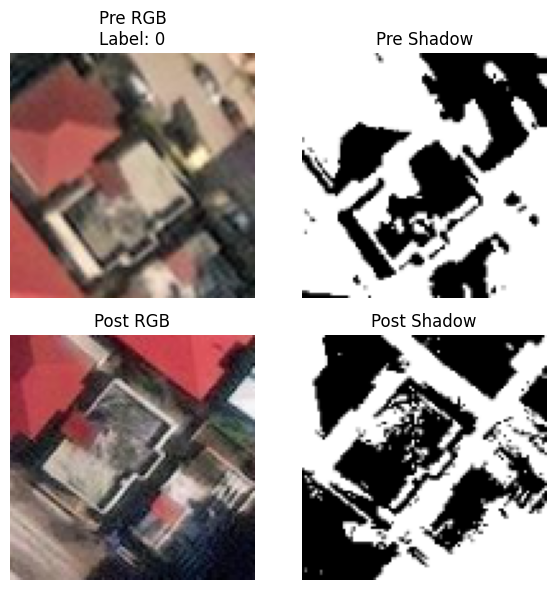

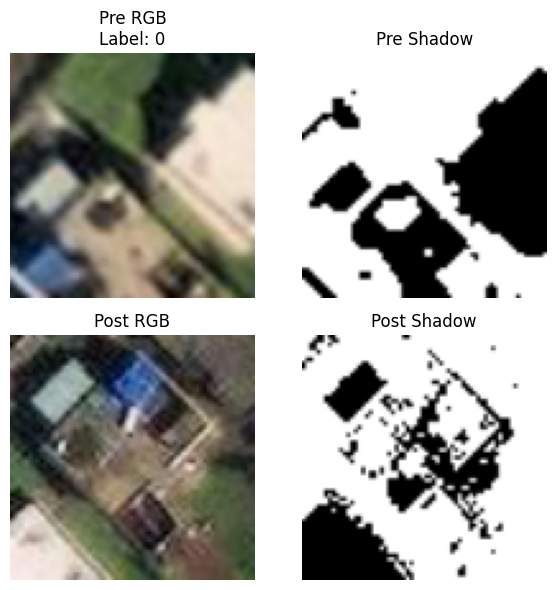

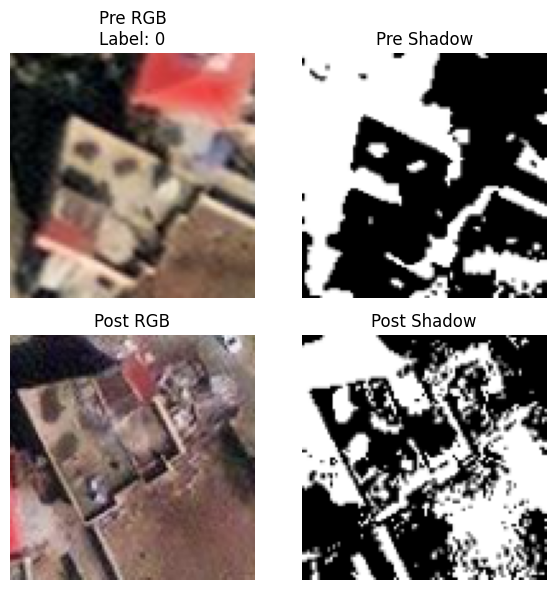

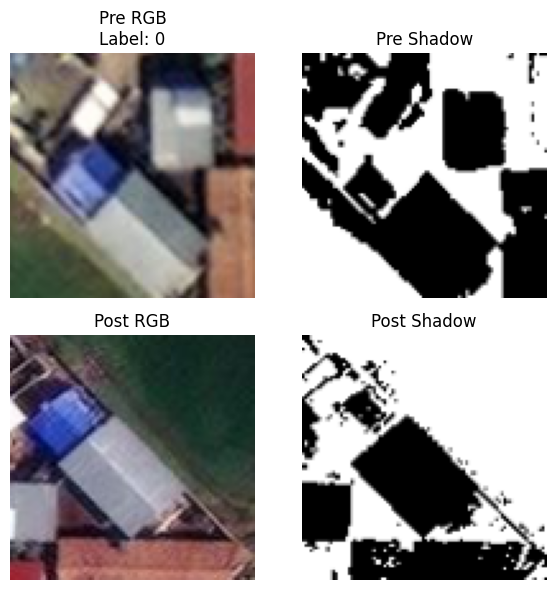

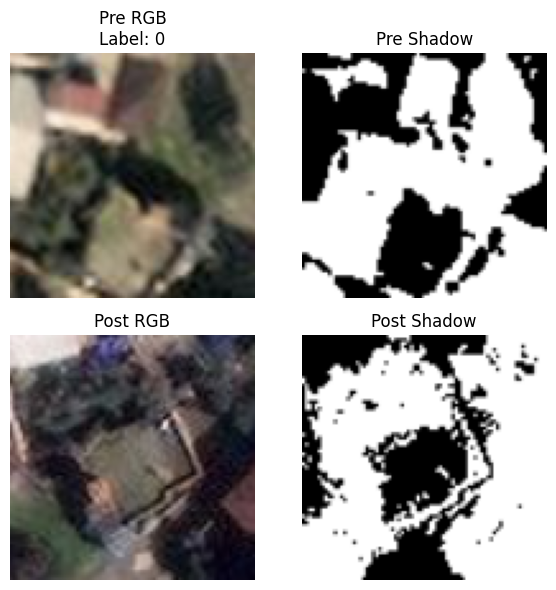

In [8]:
pkl_path = "/content/drive/MyDrive/Processed data/all_data_shadow.pkl"

with open(pkl_path, "rb") as f:
  all_data = pickle.load(f)

split_index = 0

split_data = all_data[split_index]
X_pre = split_data["X_pre"]
X_post = split_data["X_post"]
y = split_data["y"]

print(f"Split {split_index + 1} has {len(X_pre)} samples.")

num_samples = 5

for i in range(num_samples):
  img_pre = X_pre[i]
  img_post = X_post[i]
  label = y[i]

  rgb_pre = img_pre[..., :3].astype(np.uint8)
  shadow_pre = img_pre[..., 3]

  rgb_post = img_post[..., :3].astype(np.uint8)
  shadow_post = img_post[..., 3]

  fig, axs = plt.subplots(2, 2, figsize=(6, 6))

  axs[0, 0].imshow(rgb_pre)
  axs[0, 0].set_title(f"Pre RGB\nLabel: {label}")
  axs[0, 0].axis("off")

  axs[0, 1].imshow(shadow_pre, cmap="gray")
  axs[0, 1].set_title("Pre Shadow")
  axs[0, 1].axis("off")

  axs[1, 0].imshow(rgb_post)
  axs[1, 0].set_title("Post RGB")
  axs[1, 0].axis("off")

  axs[1, 1].imshow(shadow_post, cmap="gray")
  axs[1, 1].set_title("Post Shadow")
  axs[1, 1].axis("off")

  plt.tight_layout()
  plt.show()


# Shadow feature model
This is the Siamese SqueezeNet which takes an image of a building pre earthquake as one input and an image post earthquake as second input. Both have a shadow mask highlighting shadow areas in the image as extra channel input.


In [5]:
def build_squeezenet_feature_extractor(input_shape=(96, 96, 4)):
  '''
  SqueezeNet to output features for Siamese approach.
  '''

  inputs = Input(shape=input_shape)
  x = Conv2D(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(inputs)
  x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

  x = fire_module(x, squeeze_filters=16, expand_filters=64)
  x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

  x = fire_module(x, squeeze_filters=32, expand_filters=128)
  x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

  x = fire_module(x, squeeze_filters=48, expand_filters=192)
  x = Dropout(0.5)(x)

  return Model(inputs, x, name='SqueezeNetFeatureExtractor')

def siamese_squeezenet_classifier_sub(input_shape_pre=(96, 96, 4), input_shape_post=(96, 96, 4)):
  '''
  Siamese squeezenet for shadow changes that subtracts features from both branches.
  '''
  input_pre = Input(shape=input_shape_pre)
  input_post = Input(shape=input_shape_post)

  shared_squeezenet = build_squeezenet_feature_extractor(input_shape=input_shape_pre)

  feat_pre = shared_squeezenet(input_pre)
  feat_post = shared_squeezenet(input_post)

  vec1 = GlobalAveragePooling2D()(feat_pre)
  vec2 = GlobalAveragePooling2D()(feat_post)

  fused = Subtract()([vec1, vec2])

  fused = layers.Dense(128, activation='relu')(fused)
  fused = layers.Dropout(0.5)(fused)
  final_output = layers.Dense(1, activation='sigmoid')(fused)
  model = Model(inputs=[input_pre, input_post], outputs=final_output)

  return model

def siamese_squeezenet_classifier_con(input_shape_pre=(96, 96, 4), input_shape_post=(96, 96, 4)):
  '''
  Siamese squeezenet for shadow changes that concatenates features from both branches.
  '''
  input_pre = Input(shape=input_shape_pre)
  input_post = Input(shape=input_shape_post)

  shared_squeezenet = build_squeezenet_feature_extractor(input_shape=input_shape_pre)

  feat_pre = shared_squeezenet(input_pre)
  feat_post = shared_squeezenet(input_post)

  vec1 = GlobalAveragePooling2D()(feat_pre)
  vec2 = GlobalAveragePooling2D()(feat_post)

  fused = concatenate([vec1, vec2])

  fused = layers.Dense(128, activation='relu')(fused)
  fused = layers.Dropout(0.5)(fused)
  final_output = layers.Dense(1, activation='sigmoid')(fused)
  model = Model(inputs=[input_pre, input_post], outputs=final_output)

  return model

In [ ]:
def hybrid_resample_dual(X_pre, X_post, y, seed=1):
  '''
  Similar approach as used in the baseline but now image pairs have to be resampled
  '''
  np.random.seed(seed)

  X_pre = np.array(X_pre)
  X_post = np.array(X_post)
  y = np.array(y)

  idx_major = np.where(y == 0)[0]
  idx_minor = np.where(y == 1)[0]

  n_major = len(idx_major)
  n_minor = len(idx_minor)
  target_n = int((n_major + n_minor) / 2)

  idx_major_bal = np.random.choice(idx_major, target_n, replace=False)
  idx_minor_bal = np.random.choice(idx_minor, target_n, replace=True)

  idx_combined = np.concatenate([idx_major_bal, idx_minor_bal])
  np.random.shuffle(idx_combined)

  return X_pre[idx_combined], X_post[idx_combined], y[idx_combined]

In [ ]:
class SiameseSqueezeTrainer:
  def __init__(self, pickle_path, model_fn, oversample_fn=None):
    with open(pickle_path, 'rb') as f:
      self.all_data = pickle.load(f)
    self.model_fn = model_fn
    self.oversample_fn = oversample_fn
    self.all_precisions = []
    self.all_recalls = []
    self.all_f1s = []
    self.all_aurocs = []

  def train_and_evaluate(self, epochs=15, batch_size=32, verbose=1):
    for test_idx in range(5):
      print(f"Fold {test_idx + 1}")

      X_test_pre = self.all_data[test_idx]['X_pre']
      X_test_post = self.all_data[test_idx]['X_post']
      y_test = self.all_data[test_idx]['y']

      train_indices = [i for i in range(5) if i != test_idx]
      X_train_pre = np.concatenate([self.all_data[i]['X_pre'] for i in train_indices])
      X_train_post = np.concatenate([self.all_data[i]['X_post'] for i in train_indices])
      y_train = np.concatenate([self.all_data[i]['y'] for i in train_indices])

      if self.oversample_fn:
        X_train_pre, X_train_post, y_train = self.oversample_fn(X_train_pre, X_train_post, y_train)

      print(f"Train after resample - Intact: {np.sum(y_train == 0)}, Damaged: {np.sum(y_train == 1)}")
      print(f"Test  - Intact: {np.sum(y_test == 0)}, Damaged: {np.sum(y_test == 1)}")

      X_train_pre = X_train_pre.astype('float32') / 255.0
      X_train_post = X_train_post.astype('float32') / 255.0
      X_test_pre = X_test_pre.astype('float32') / 255.0
      X_test_post = X_test_post.astype('float32') / 255.0

      model = self.model_fn(input_shape_pre=X_train_pre.shape[1:], input_shape_post=X_train_post.shape[1:])
      model.compile(optimizer=AdamW(), loss='binary_crossentropy', metrics=['Precision', 'Recall', AUC(curve='ROC', name='AUC')])

      model.fit(
          [X_train_pre, X_train_post], y_train,
          epochs=epochs,
          batch_size=batch_size,
          verbose=verbose
      )

      y_pred_probs = model.predict([X_test_pre, X_test_post]).squeeze()
      precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_probs)
      f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

      best_idx = np.argmax(f1_scores)
      best_threshold = thresholds[best_idx]
      print(f"Best F1 Threshold: {best_threshold:.4f} — F1: {f1_scores[best_idx]:.4f}")

      y_pred = (y_pred_probs > best_threshold).astype(int)

      precision = precision_score(y_test, y_pred, zero_division=0)
      recall = recall_score(y_test, y_pred, zero_division=0)
      f1 = f1_score(y_test, y_pred, zero_division=0)
      auroc = roc_auc_score(y_test, y_pred_probs)

      self.all_aurocs.append(auroc)
      self.all_precisions.append(precision)
      self.all_recalls.append(recall)
      self.all_f1s.append(f1)

      print(classification_report(y_test, y_pred, digits=4, zero_division=0))

    img_2 = visualkeras.layered_view(model, legend=True)
    display(img_2)
    self.print_summary()

  def print_summary(self):
    print("Cross-Validation Summary")
    print(f"Mean Precision: {np.mean(self.all_precisions):.4f}")
    print(f"Mean Recall: {np.mean(self.all_recalls):.4f}")
    print(f"Mean F1 Score: {np.mean(self.all_f1s):.4f}")
    print(f"Mean AUROC: {np.mean(self.all_aurocs):.4f}")

    print(f"Std. dev Precision: {np.std(self.all_precisions):.4f}")
    print(f"Std. dev Recall: {np.std(self.all_recalls):.4f}")
    print(f"Std. dev F1 Score: {np.std(self.all_f1s):.4f}")
    print(f"Std. dev AUROC: {np.std(self.all_aurocs):.4f}")


    metrics = {
        'Precision': self.all_precisions,
        'Recall': self.all_recalls,
        'F1 Score': self.all_f1s,
        'AUROC': self.all_aurocs
    }

    folds = list(range(1, 6))

    plt.figure(figsize=(10, 6))
    precision_line, = plt.plot(folds, self.all_precisions, marker='o', label='Precision')
    recall_line, = plt.plot(folds, self.all_recalls, marker='o', label='Recall')
    f1_line, = plt.plot(folds, self.all_f1s, marker='o', label='F1 Score')
    auroc_line, = plt.plot(folds, self.all_aurocs, marker='o', label='AUROC')

    plt.axhline(np.mean(self.all_f1s), color=f1_line.get_color(), linestyle='--', label='Mean F1')
    plt.axhline(np.mean(self.all_precisions), color=precision_line.get_color(), linestyle='--', label='Mean Precision')
    plt.axhline(np.mean(self.all_recalls), color=recall_line.get_color(), linestyle='--', label='Mean Recall')
    plt.axhline(np.mean(self.all_aurocs), color=auroc_line.get_color(), linestyle='--', label='Mean AUROC')

    plt.xlabel('Fold')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    # plt.title('Performance per Fold')
    # plt.legend()
    plt.grid(True)
    plt.show()


Fold 1
Train after resample - Intact: 1604, Damaged: 1604
Test  - Intact: 767, Damaged: 34
Epoch 1/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - AUC: 0.6108 - Precision: 0.5359 - Recall: 0.8062 - loss: 0.6719
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - AUC: 0.8294 - Precision: 0.7799 - Recall: 0.7369 - loss: 0.5076
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - AUC: 0.8743 - Precision: 0.8243 - Recall: 0.7687 - loss: 0.4458
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.8947 - Precision: 0.8470 - Recall: 0.7896 - loss: 0.4059
Epoch 5/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - AUC: 0.9334 - Precision: 0.8750 - Recall: 0.8326 - loss: 0.3304
Epoch 6/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - AUC: 0.9566 - Precision: 0.8921 - Recall: 0.8925 - loss: 0.2668
Epoch 7/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.9771 - Precision: 0.9274 - Recall: 0.9375 - loss: 0.1892
Epoch 8/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - AUC: 0.9807 - Precis

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


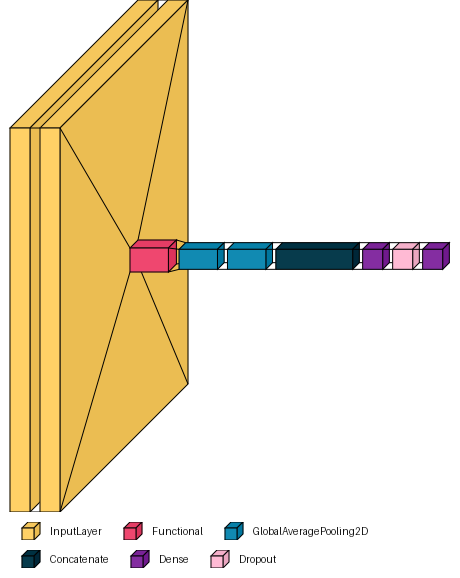

Cross-Validation Summary
Mean Precision: 0.5313
Mean Recall: 0.4021
Mean F1 Score: 0.4511
Mean AUROC: 0.8586
Std. dev Precision: 0.0896
Std. dev Recall: 0.0812
Std. dev F1 Score: 0.0662
Std. dev AUROC: 0.0470


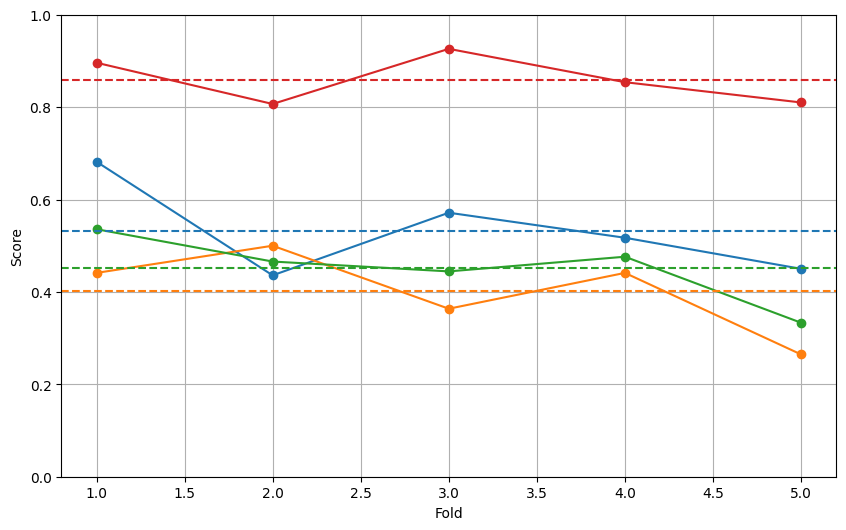

In [ ]:
trainer = SiameseSqueezeTrainer(
    pickle_path='/content/drive/MyDrive/Processed data/all_data_shadow.pkl',
    model_fn=siamese_squeezenet_classifier_con,
    oversample_fn=hybrid_resample_dual
)

trainer.train_and_evaluate(epochs=30, batch_size=32)

Fold 1
Train after resample - Intact: 1604, Damaged: 1604
Test  - Intact: 767, Damaged: 34
Epoch 1/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - AUC: 0.6706 - Precision: 0.5876 - Recall: 0.7939 - loss: 0.6532
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - AUC: 0.8542 - Precision: 0.7684 - Recall: 0.8175 - loss: 0.4821
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - AUC: 0.9166 - Precision: 0.8285 - Recall: 0.8418 - loss: 0.3726
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - AUC: 0.9390 - Precision: 0.8744 - Recall: 0.8682 - loss: 0.3202
Epoch 5/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.9663 - Precision: 0.9043 - Recall: 0.9354 - loss: 0.2301
Epoch 6/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.9668 - Precision: 0.8982 - Recall: 0.9419 - loss: 0.2297
Epoch 7/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - AUC: 0.9843 - Precision: 0.9348 - Recall: 0.9713 - loss: 0.1433
Epoch 8/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - AUC: 0.9898 - Preci

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


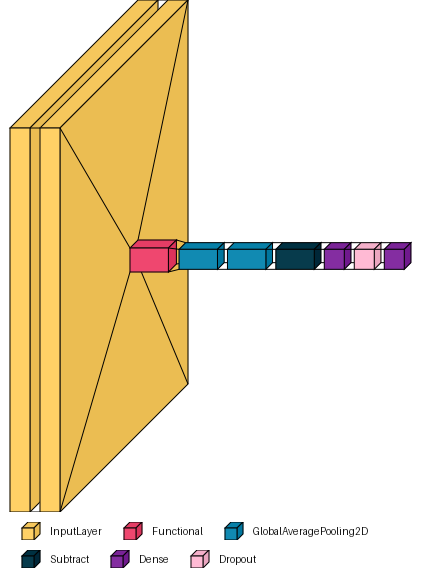

Cross-Validation Summary
Mean Precision: 0.5459
Mean Recall: 0.3909
Mean F1 Score: 0.4315
Mean AUROC: 0.8409
Std. dev Precision: 0.0940
Std. dev Recall: 0.1181
Std. dev F1 Score: 0.0642
Std. dev AUROC: 0.0305


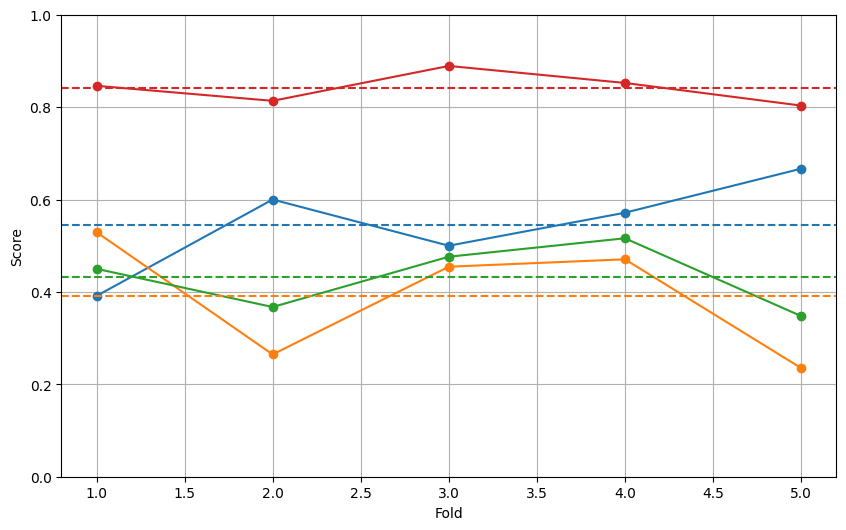

In [ ]:
trainer = SiameseSqueezeTrainer(
    pickle_path='/content/drive/MyDrive/Processed data/all_data_shadow.pkl',
    model_fn=siamese_squeezenet_classifier_sub,
    oversample_fn=hybrid_resample_dual
)

trainer.train_and_evaluate(epochs=30, batch_size=32)

# Combined model predictions
This is a combined model to see if seperatly processing images with emphasis on shadows with a CNN impacts the performance of building classification. This particular methodology combines the probability outputs of the siamese shadow change cnn and the regular baseline.

In [6]:
def hybrid_resample_aligned(X_post, X_pre_shadow, X_post_shadow, y, seed=1):
  '''
  Now resampling needs to happen for two models and two inputs.
  To keep them alligned the indexes are resampled and those same indexes are applied to every data set input to keep all buildings
  alligned correspondingly.
  '''
  np.random.seed(seed)

  X_post = np.array(X_post)
  X_pre_shadow = np.array(X_pre_shadow)
  X_post_shadow = np.array(X_post_shadow)
  y = np.array(y)

  idx_major = np.where(y == 0)[0]
  idx_minor = np.where(y == 1)[0]

  n_major = len(idx_major)
  n_minor = len(idx_minor)
  target_n = int((n_major + n_minor) / 2)

  idx_major_bal = np.random.choice(idx_major, target_n, replace=False)
  idx_minor_bal = np.random.choice(idx_minor, target_n, replace=True)

  idx_combined = np.concatenate([idx_major_bal, idx_minor_bal])
  np.random.shuffle(idx_combined)

  return (
      X_post[idx_combined],
      X_pre_shadow[idx_combined],
      X_post_shadow[idx_combined],
      y[idx_combined]
  )


In [7]:
def combined_model_con():
  '''
  This combined model uses the siamese shadow change squeezenet with concatenated features.
  '''
  regular_input = Input(shape=(96, 96, 4), name="regular_input")  # Regular SqueezeNet branch.
  squeezenet_model = build_squeezenet(input_shape=(96, 96, 4))
  regular_output = squeezenet_model(regular_input)

  pre_input = Input(shape=(96, 96, 4), name="pre_input")  # Siamese SqueezeNet branch.
  post_input = Input(shape=(96, 96, 4), name="post_input")
  siamese_model = siamese_squeezenet_classifier_con(input_shape_pre=(96, 96, 4), input_shape_post=(96, 96, 4))
  siamese_output = siamese_model([pre_input, post_input])

  final_output = Average()([regular_output, siamese_output])

  model = Model(inputs=[regular_input, pre_input, post_input], outputs=final_output)

  return model

In [8]:
def combined_model_sub():
  '''
  This combined model uses the siamese shadow change squeezenet with subtracted features.
  '''
  regular_input = Input(shape=(96, 96, 4), name="regular_input")  # Regular SqueezeNet branch.
  squeezenet_model = build_squeezenet(input_shape=(96, 96, 4))
  regular_output = squeezenet_model(regular_input)

  pre_input = Input(shape=(96, 96, 4), name="pre_input")  # Siamese SqueezeNet branch.
  post_input = Input(shape=(96, 96, 4), name="post_input")
  siamese_model = siamese_squeezenet_classifier_sub(input_shape_pre=(96, 96, 4), input_shape_post=(96, 96, 4))
  siamese_output = siamese_model([pre_input, post_input])

  final_output = Average()([regular_output, siamese_output])

  model = Model(inputs=[regular_input, pre_input, post_input], outputs=final_output)

  return model

In [9]:
class CombinedSqueezeTrainer:
    def __init__(self, post_pickle_path, shadow_pickle_path, model_fn, oversample_regular=None, oversample_dual=None):
        # Load post-optical data for the baseline branch.
        with open(post_pickle_path, 'rb') as f:
          self.post_data = pickle.load(f)

        # Load pre and post-optical data with shadow masks for the Siamese SqueezeNet branch.
        with open(shadow_pickle_path, 'rb') as f:
          self.shadow_data = pickle.load(f)

        self.model_fn = model_fn
        self.oversample_dual = oversample_dual

        self.all_precisions = []
        self.all_recalls = []
        self.all_f1s = []
        self.all_aurocs = []

    def train_and_evaluate(self, epochs=15, batch_size=32, verbose=1):
      for test_idx in range(5):
        print(f"Fold {test_idx + 1}")

        X_test_post = self.post_data[test_idx]['X']
        y_test_post = self.post_data[test_idx]['y']

        X_test_pre_shadow = self.shadow_data[test_idx]['X_pre']
        X_test_post_shadow = self.shadow_data[test_idx]['X_post']
        y_test_shadow = self.shadow_data[test_idx]['y']

        train_indices = [i for i in range(5) if i != test_idx]
        X_train_post = np.concatenate([self.post_data[i]['X'] for i in train_indices])
        y_train_post = np.concatenate([self.post_data[i]['y'] for i in train_indices])

        X_train_pre_shadow = np.concatenate([self.shadow_data[i]['X_pre'] for i in train_indices])
        X_train_post_shadow = np.concatenate([self.shadow_data[i]['X_post'] for i in train_indices])
        y_train_shadow = np.concatenate([self.shadow_data[i]['y'] for i in train_indices])


        X_train_post, X_train_pre_shadow, X_train_post_shadow, y_train_shadow = self.oversample_dual(X_train_post, X_train_pre_shadow, X_train_post_shadow, y_train_shadow)

        print(f"Train after resample - Intact: {np.sum(y_train_shadow == 0)}, Damaged: {np.sum(y_train_shadow == 1)}")
        print(f"Test  - Intact: {np.sum(y_test_post == 0)}, Damaged: {np.sum(y_test_post == 1)}")

        X_train_post = X_train_post.astype('float32') / 255.0
        X_test_post = X_test_post.astype('float32') / 255.0

        X_train_pre_shadow = X_train_pre_shadow.astype('float32') / 255.0
        X_train_post_shadow = X_train_post_shadow.astype('float32') / 255.0
        X_test_pre_shadow = X_test_pre_shadow.astype('float32') / 255.0
        X_test_post_shadow = X_test_post_shadow.astype('float32') / 255.0

        model = self.model_fn()
        model.compile(optimizer=AdamW(), loss='binary_crossentropy', metrics=['Precision', 'Recall', AUC(curve='ROC', name='AUC')])

        model.fit(
            [X_train_post, X_train_pre_shadow, X_train_post_shadow],
            y_train_shadow,
            epochs=epochs,
            batch_size=batch_size,
            verbose=verbose
        )

        y_pred_probs = model.predict([X_test_post, X_test_pre_shadow, X_test_post_shadow]).squeeze()
        precisions, recalls, thresholds = precision_recall_curve(y_test_shadow, y_pred_probs)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

        best_idx = np.argmax(f1_scores)
        best_threshold = thresholds[best_idx]
        print(f"Best F1 Threshold: {best_threshold:.4f} — F1: {f1_scores[best_idx]:.4f}")

        y_pred = (y_pred_probs > best_threshold).astype(int)

        precision = precision_score(y_test_shadow, y_pred, zero_division=0)
        recall = recall_score(y_test_shadow, y_pred, zero_division=0)
        f1 = f1_score(y_test_shadow, y_pred, zero_division=0)
        auroc = roc_auc_score(y_test_shadow, y_pred_probs)

        self.all_aurocs.append(auroc)
        self.all_precisions.append(precision)
        self.all_recalls.append(recall)
        self.all_f1s.append(f1)

        print(classification_report(y_test_shadow, y_pred, digits=4, zero_division=0))

      self.print_summary()

    def print_summary(self):
      print("Cross-Validation Summary")
      print(f"Mean Precision: {np.mean(self.all_precisions):.4f}")
      print(f"Mean Recall: {np.mean(self.all_recalls):.4f}")
      print(f"Mean F1 Score: {np.mean(self.all_f1s):.4f}")
      print(f"Mean AUROC: {np.mean(self.all_aurocs):.4f}")

      print(f"Std. dev Precision: {np.std(self.all_precisions):.4f}")
      print(f"Std. dev Recall: {np.std(self.all_recalls):.4f}")
      print(f"Std. dev F1 Score: {np.std(self.all_f1s):.4f}")
      print(f"Std. dev AUROC: {np.std(self.all_aurocs):.4f}")



      metrics = {
          'Precision': self.all_precisions,
          'Recall': self.all_recalls,
          'F1 Score': self.all_f1s,
          'AUROC': self.all_aurocs
      }



      folds = list(range(1, 6))

      plt.figure(figsize=(10, 6))
      precision_line, = plt.plot(folds, self.all_precisions, marker='o', label='Precision')
      recall_line, = plt.plot(folds, self.all_recalls, marker='o', label='Recall')
      f1_line, = plt.plot(folds, self.all_f1s, marker='o', label='F1 Score')
      auroc_line, = plt.plot(folds, self.all_aurocs, marker='o', label='AUROC')

      plt.axhline(np.mean(self.all_f1s), color=f1_line.get_color(), linestyle='--', label='Mean F1')
      plt.axhline(np.mean(self.all_precisions), color=precision_line.get_color(), linestyle='--', label='Mean Precision')
      plt.axhline(np.mean(self.all_recalls), color=recall_line.get_color(), linestyle='--', label='Mean Recall')
      plt.axhline(np.mean(self.all_aurocs), color=auroc_line.get_color(), linestyle='--', label='Mean AUROC')

      plt.xlabel('Fold')
      plt.ylabel('Score')
      plt.ylim(0, 1)
      # plt.title('Performance per Fold')
      # plt.legend()
      plt.grid(True)
      plt.show()


Fold 1
Train after resample - Intact: 1604, Damaged: 1604
Test  - Intact: 767, Damaged: 34
Epoch 1/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 39s 113ms/step - AUC: 0.5323 - Precision: 0.5180 - Recall: 0.4648 - loss: 0.6892
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - AUC: 0.7736 - Precision: 0.7203 - Recall: 0.6876 - loss: 0.5784
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - AUC: 0.8033 - Precision: 0.7498 - Recall: 0.7134 - loss: 0.5526
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - AUC: 0.8219 - Precision: 0.7546 - Recall: 0.7653 - loss: 0.5343
Epoch 5/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - AUC: 0.7606 - Precision: 0.6851 - Recall: 0.8012 - loss: 0.5844
Epoch 6/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - AUC: 0.7223 - Precision: 0.6352 - Recall: 0.7447 - loss: 0.6351
Epoch 7/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - AUC: 0.8839 - Precision: 0.8248 - Recall: 0.8034 - loss: 0.4308
Epoch 8/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - AUC: 0.9056 - Preci

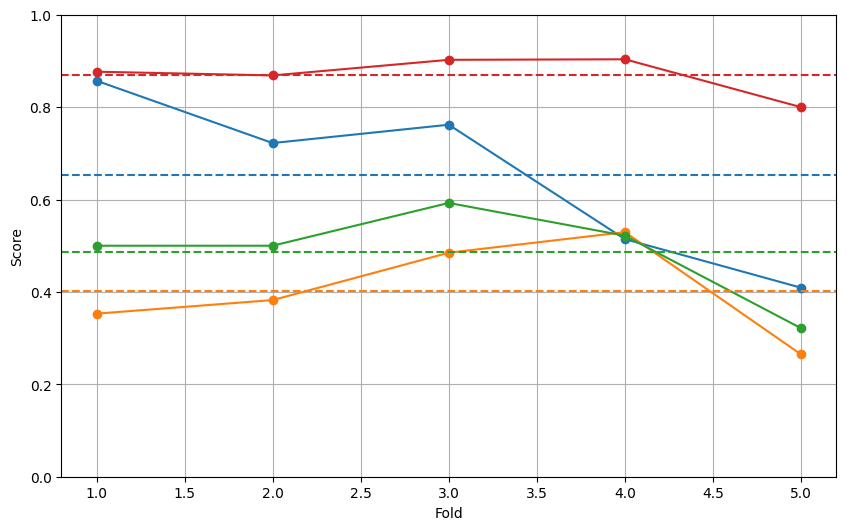

In [ ]:
trainer = CombinedSqueezeTrainer(
    post_pickle_path="/content/drive/MyDrive/Processed data/all_data.pkl",
    shadow_pickle_path="/content/drive/MyDrive/Processed data/all_data_shadow.pkl",
    model_fn=combined_model_con,
    oversample_dual=hybrid_resample_aligned
)

trainer.train_and_evaluate(epochs=30, batch_size=32, verbose=1)


Fold 1
Train after resample - Intact: 1604, Damaged: 1604
Test  - Intact: 767, Damaged: 34
Epoch 1/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - AUC: 0.6735 - Precision: 0.5762 - Recall: 0.8133 - loss: 0.6481
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - AUC: 0.8532 - Precision: 0.7570 - Recall: 0.7986 - loss: 0.4865
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - AUC: 0.8717 - Precision: 0.8020 - Recall: 0.7733 - loss: 0.4533
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - AUC: 0.9107 - Precision: 0.8186 - Recall: 0.8492 - loss: 0.3851
Epoch 5/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - AUC: 0.9273 - Precision: 0.8738 - Recall: 0.8259 - loss: 0.3659
Epoch 6/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - AUC: 0.9273 - Precision: 0.8413 - Recall: 0.8651 - loss: 0.3548
Epoch 7/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - AUC: 0.9597 - Precision: 0.8941 - Recall: 0.9180 - loss: 0.2806
Epoch 8/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - AUC: 0.9613 - Preci

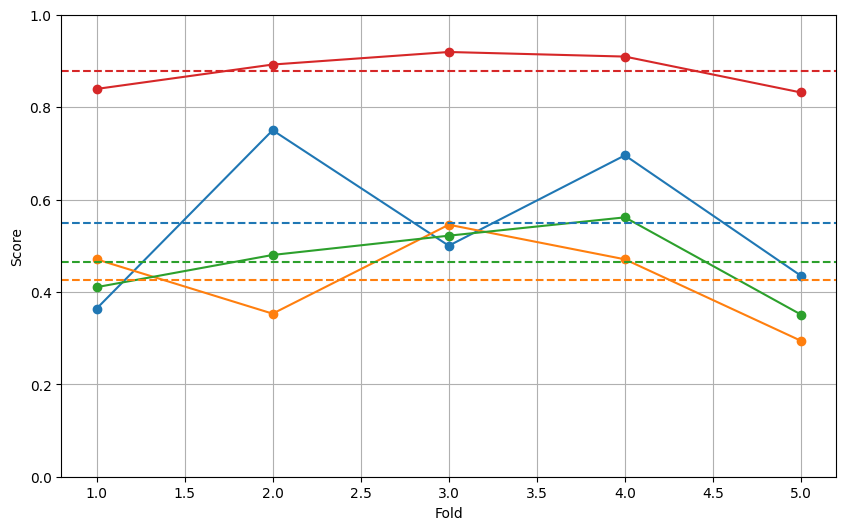

In [ ]:
trainer = CombinedSqueezeTrainer(
    post_pickle_path="/content/drive/MyDrive/Processed data/all_data.pkl",
    shadow_pickle_path="/content/drive/MyDrive/Processed data/all_data_shadow.pkl",
    model_fn=combined_model_sub,
    oversample_dual=hybrid_resample_aligned
)

trainer.train_and_evaluate(epochs=30, batch_size=32, verbose=1)

# Combined model features
This is a combined model to see if seperatly processing images with emphasis on shadows with a CNN impacts the performance of building classification. This particular methodology combines the feature map outputs of the siamese shadow change cnn and the regular baseline.


In [10]:
def siamese_squeezenet_features_con(input_shape_pre=(96, 96, 4), input_shape_post=(96, 96, 4)):
  '''
  Adapted siamese shadow change network so that it outputs the feature maps of concatenation of branches.
  '''
  input_pre = Input(shape=input_shape_pre)
  input_post = Input(shape=input_shape_post)

  shared_squeezenet = build_squeezenet_feature_extractor(input_shape=input_shape_pre)

  feat_pre = shared_squeezenet(input_pre)
  feat_post = shared_squeezenet(input_post)

  vec1 = GlobalAveragePooling2D()(feat_pre)
  vec2 = GlobalAveragePooling2D()(feat_post)

  fused = concatenate([vec1, vec2])

  model = Model(inputs=[input_pre, input_post], outputs=fused)
  return model


In [11]:
def siamese_squeezenet_features_sub(input_shape_pre=(96, 96, 4), input_shape_post=(96, 96, 4)):
  '''
  Adapted siamese shadow change network so that it outputs the feature maps of subtraction of branches.
  '''
  input_pre = Input(shape=input_shape_pre)
  input_post = Input(shape=input_shape_post)

  shared_squeezenet = build_squeezenet_feature_extractor(input_shape=input_shape_pre)

  feat_pre = shared_squeezenet(input_pre)
  feat_post = shared_squeezenet(input_post)

  vec1 = GlobalAveragePooling2D()(feat_pre)
  vec2 = GlobalAveragePooling2D()(feat_post)

  fused = Subtract()([vec1, vec2])


  model = Model(inputs=[input_pre, input_post], outputs=fused)
  return model

In [12]:
def combined_model_features_con():
  '''
  combined model wiht concatenated shadows.
  '''
  regular_input = Input(shape=(96, 96, 4), name="regular_input")
  squeezenet_model = build_squeezenet_feature_extractor(input_shape=(96, 96, 4))
  regular_output = squeezenet_model(regular_input)
  regular_output = GlobalAveragePooling2D()(regular_output)

  pre_input = Input(shape=(96, 96, 4), name="pre_input")
  post_input = Input(shape=(96, 96, 4), name="post_input")
  siamese_model = siamese_squeezenet_features_con(input_shape_pre=(96, 96, 4), input_shape_post=(96, 96, 4))
  siamese_output = siamese_model([pre_input, post_input])

  fused = concatenate([regular_output, siamese_output])

  fused = layers.Dense(128, activation='relu')(fused)
  fused = layers.Dropout(0.5)(fused)
  final_output = layers.Dense(1, activation='sigmoid')(fused)

  model = Model(inputs=[regular_input, pre_input, post_input], outputs=final_output)
  model.compile(optimizer=AdamW(), loss='binary_crossentropy', metrics=['Precision', 'Recall'])

  return model

In [13]:
def combined_model_features_sub():
  '''
  combined model with subtracted shadows.
  '''
  regular_input = Input(shape=(96, 96, 4), name="regular_input")
  squeezenet_model = build_squeezenet_feature_extractor(input_shape=(96, 96, 4))
  regular_output = squeezenet_model(regular_input)
  regular_output = GlobalAveragePooling2D()(regular_output)

  pre_input = Input(shape=(96, 96, 4), name="pre_input")
  post_input = Input(shape=(96, 96, 4), name="post_input")
  siamese_model = siamese_squeezenet_features_sub(input_shape_pre=(96, 96, 4), input_shape_post=(96, 96, 4))
  siamese_output = siamese_model([pre_input, post_input])

  fused = concatenate([regular_output, siamese_output])

  fused = layers.Dense(128, activation='relu')(fused)
  fused = layers.Dropout(0.5)(fused)
  final_output = layers.Dense(1, activation='sigmoid')(fused)

  model = Model(inputs=[regular_input, pre_input, post_input], outputs=final_output)
  model.compile(optimizer=AdamW(), loss='binary_crossentropy', metrics=['Precision', 'Recall'])

  return model

Fold 1
Train after resample - Intact: 1604, Damaged: 1604
Test  - Intact: 767, Damaged: 34
Epoch 1/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 31s 116ms/step - AUC: 0.5558 - Precision: 0.5446 - Recall: 0.5544 - loss: 0.6849
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - AUC: 0.7560 - Precision: 0.6862 - Recall: 0.6850 - loss: 0.5900
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 0.8137 - Precision: 0.7724 - Recall: 0.7274 - loss: 0.5346
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - AUC: 0.8745 - Precision: 0.8104 - Recall: 0.7707 - loss: 0.4433
Epoch 5/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - AUC: 0.8585 - Precision: 0.7831 - Recall: 0.7827 - loss: 0.4708
Epoch 6/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - AUC: 0.8467 - Precision: 0.7915 - Recall: 0.7343 - loss: 0.4931
Epoch 7/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - AUC: 0.9106 - Precision: 0.8384 - Recall: 0.8109 - loss: 0.3828
Epoch 8/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - AUC: 0.9311 - Prec

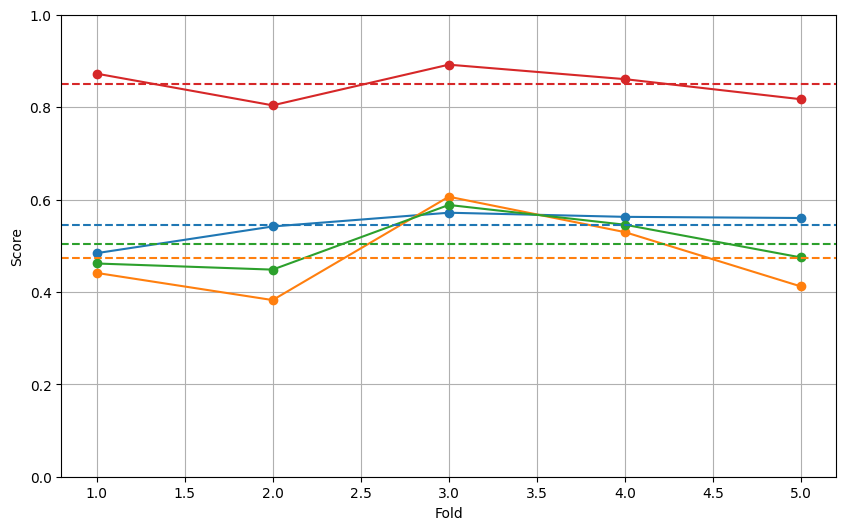

In [14]:
trainer = CombinedSqueezeTrainer(
    post_pickle_path="/content/drive/MyDrive/Processed data/all_data.pkl",
    shadow_pickle_path="/content/drive/MyDrive/Processed data/all_data_shadow.pkl",
    model_fn=combined_model_features_con,
    oversample_dual=hybrid_resample_aligned
)

trainer.train_and_evaluate(epochs=30, batch_size=32, verbose=1)

Fold 1
Train after resample - Intact: 1604, Damaged: 1604
Test  - Intact: 767, Damaged: 34
Epoch 1/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 27s 95ms/step - AUC: 0.6250 - Precision: 0.5752 - Recall: 0.8552 - loss: 0.6591
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 0.8827 - Precision: 0.8333 - Recall: 0.8012 - loss: 0.4286
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - AUC: 0.9084 - Precision: 0.8445 - Recall: 0.7982 - loss: 0.3896
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - AUC: 0.9415 - Precision: 0.8721 - Recall: 0.8825 - loss: 0.3114
Epoch 5/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - AUC: 0.9602 - Precision: 0.8945 - Recall: 0.9187 - loss: 0.2573
Epoch 6/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - AUC: 0.9686 - Precision: 0.8941 - Recall: 0.9251 - loss: 0.2294
Epoch 7/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - AUC: 0.9785 - Precision: 0.9197 - Recall: 0.9481 - loss: 0.1808
Epoch 8/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - AUC: 0.9902 - Precis

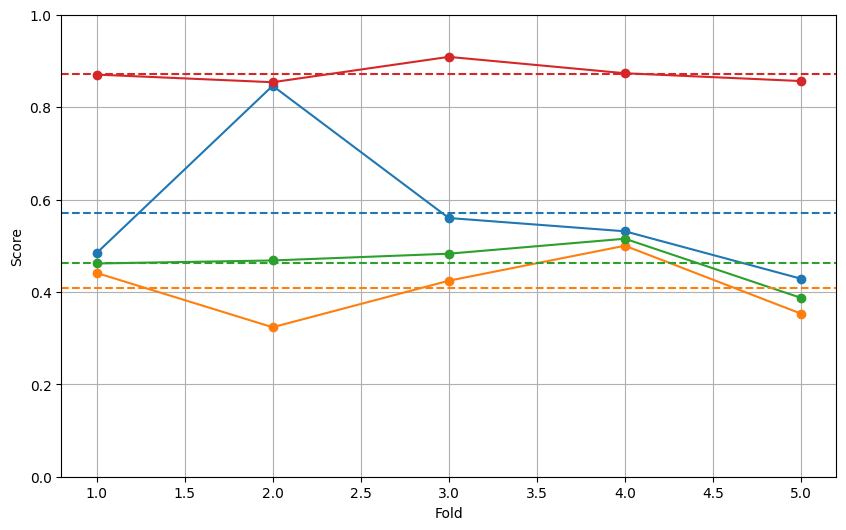

In [15]:
trainer = CombinedSqueezeTrainer(
    post_pickle_path="/content/drive/MyDrive/Processed data/all_data.pkl",
    shadow_pickle_path="/content/drive/MyDrive/Processed data/all_data_shadow.pkl",
    model_fn=combined_model_features_sub,
    oversample_dual=hybrid_resample_aligned
)

trainer.train_and_evaluate(epochs=30, batch_size=32, verbose=1)